# Data Mining Final Project: People Analytics - IBM HR Dataset

## Script Overview: 

### Abstract
+ **Project goals**: 
+ **Description of data**:
+ **Variable definitions**: 
+ **Methods**: 
+ **Summary of conclusions**: 
+ **Limitations and risks**: 

### Table of Contents
+ **Step 1**: Environment set-up and data load
+ **Step 2**: Exploratory data analysis (EDA) and data processing
+ **Step 3**: Dimensionality reduction
+ **Step 4**: Clustering
+ **Step 5**: Linear classification models
+ **Step 6**: Non-linear classification models
+ **Step 7**: Graph anaylsis (???)

## Step 1: Environment set-up and data load

In [18]:
# Data processing
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from scipy import stats

# Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
from pandas.plotting import scatter_matrix

# Model functions
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

# Ignore Pandas warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
df  = pd.read_csv('data/WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## Step 2: EDA and data processing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [4]:
# Getting a sense of how many categories we're dealing with
print(df['Attrition'].unique())
print(df['BusinessTravel'].unique())
print(df['Department'].unique())
print(df['EducationField'].unique())

['Yes' 'No']
['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
['Sales' 'Research & Development' 'Human Resources']
['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']


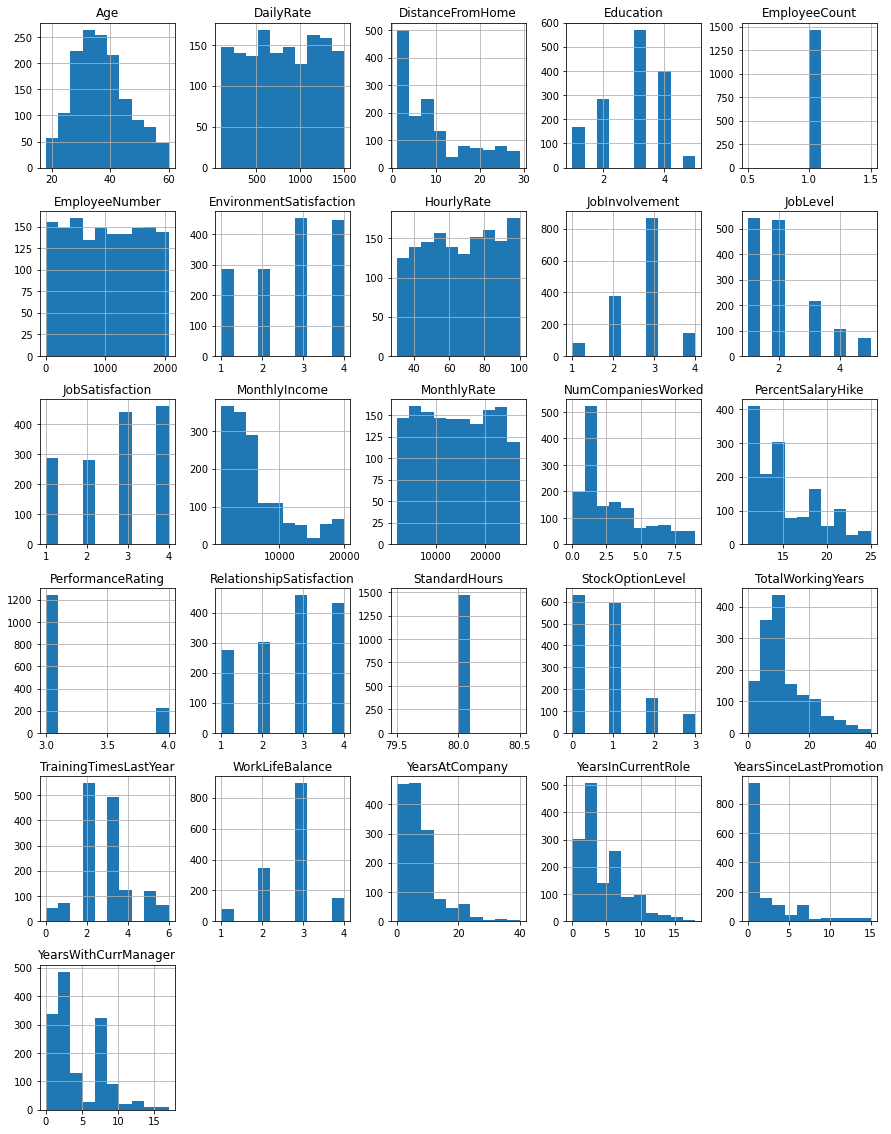

In [5]:
# Plotting distributions
fig = plt.figure(figsize = (15,20));
ax = fig.gca();
df.hist(ax = ax)
pass # Added to hide the plot messages

# Imbalanced training set we''ll need to address (1200 still there, 200 attritioned)
# Most employees are close to the office (within 10 miles)

# Education, Environment Satisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, 
# RelationshipSatisfaction, WorkLifeBalance should also probably be treated as categorical 

In [6]:
#TODO plot attrition by subgroups --> consider adding attrition into corr plot

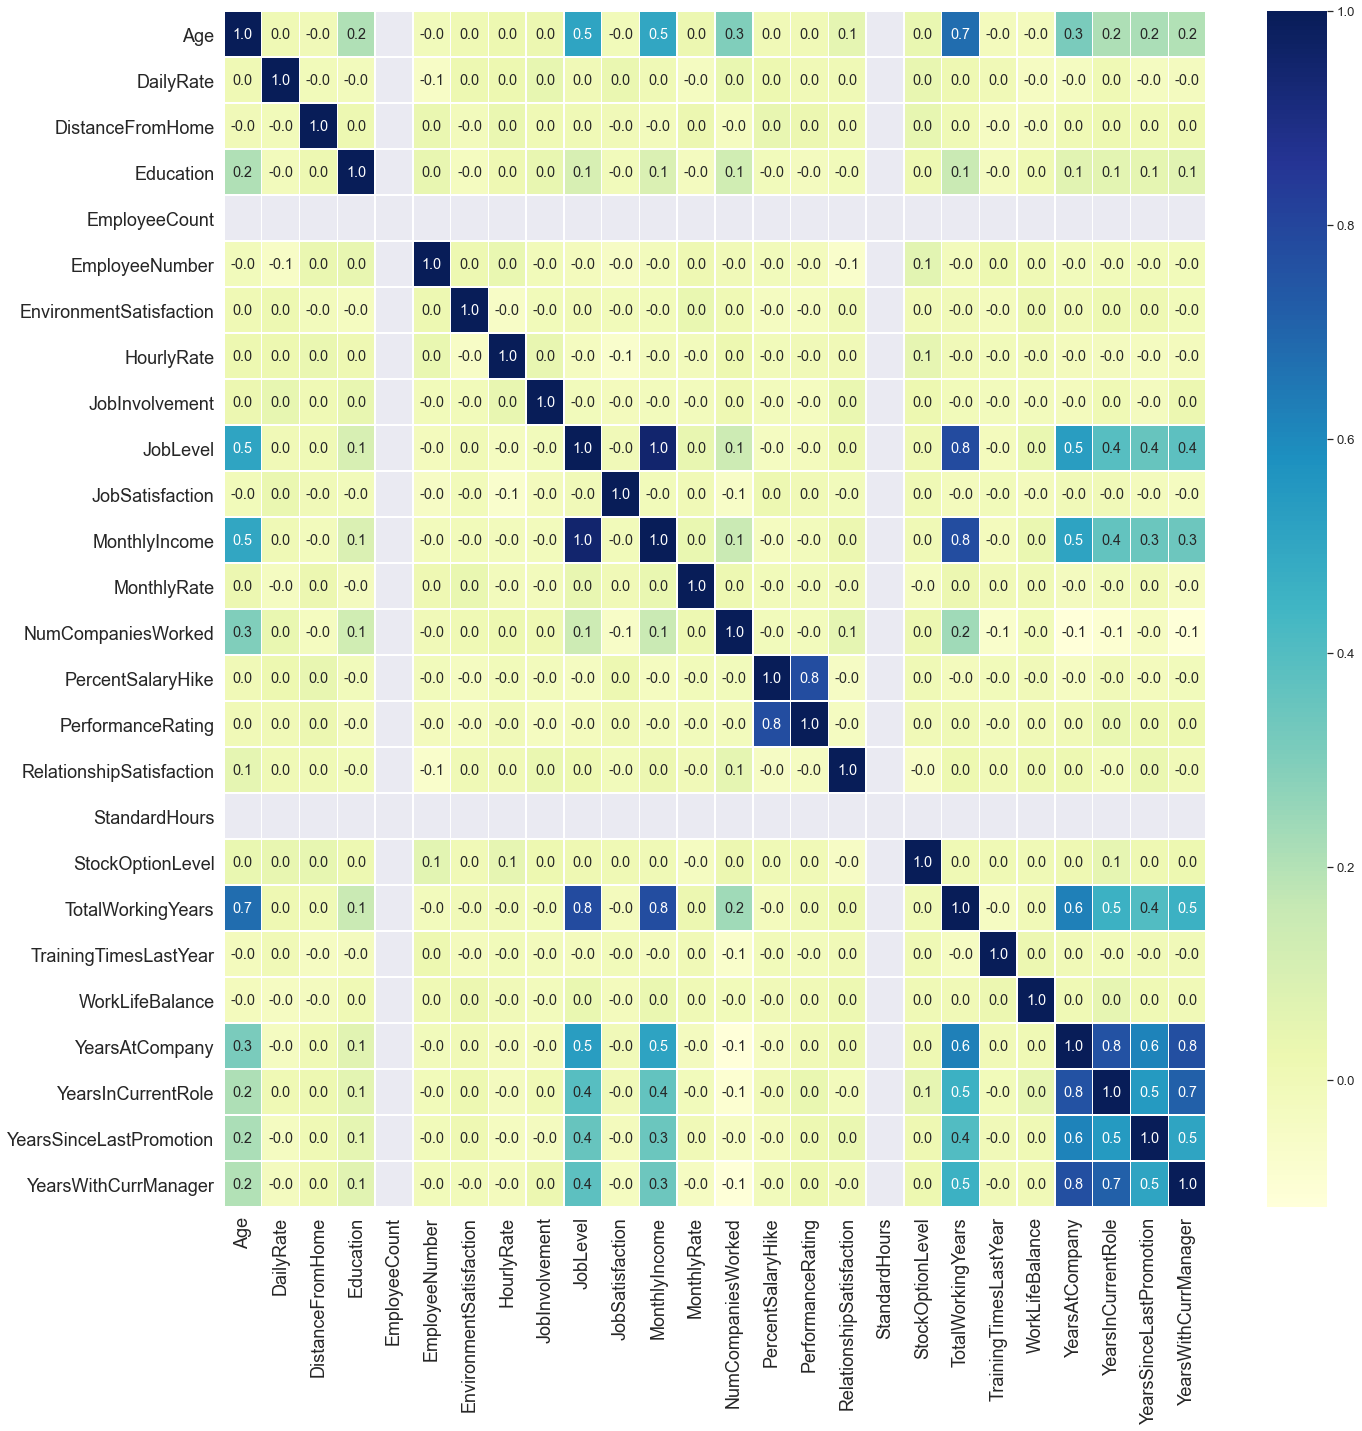

In [7]:
# Heatmap of correlations
# Low correlation for most fields, dispelling some concerns about multicollinearity. Should be able to use all predictors
sns.set(font_scale=1.2)# Increase font size of corr values

f,ax = plt.subplots(figsize=(22, 22))
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 18)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 18)
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap="YlGnBu")
pass

In [8]:
# Using a scatter matrix to visualize correlations
# TODO - if using, need to select only first 30 or so features since new features are not at all correlated
# pd.plotting.scatter_matrix(df, figsize=(15, 15))
# fig=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
# plt.show()

In [9]:
# Create a label encoder object
le = LabelEncoder()

In [10]:
plt.rcParams['figure.figsize'] = (18,18)
print('Size of initial unencoded dataset (categorical columns intact): {}'. format(df.shape))
df.head()

Size of initial unencoded dataset (categorical columns intact): (1470, 35)


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [11]:
# Label Encoding will be used for columns with 2 or less unique values - creates new binary columns for their unique values
le_count = 0
for col in df.columns[1:]:
    if df[col].dtype == 'object':
        if len(list(df[col].unique())) <= 2:
            le.fit(df[col])
            df[col] = le.transform(df[col])
            le_count += 1
print('{} columns were label encoded.'.format(le_count))

4 columns were label encoded.


In [12]:
# convert rest of categorical variable into dummy
df = pd.get_dummies(df, drop_first=True)
print('Size of Full Encoded Dataset (new binary columns created): {}'. format(df.shape))
df.head()
# df.info()

Size of Full Encoded Dataset (new binary columns created): (1470, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,...,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,...,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,...,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,...,0,1,0,0,0,0,0,0,1,0


In [13]:
# Creating our target dataframe
target = df['Attrition'].copy()

# Drpoping attrition
print('Size of Full dataset is: {}'.format(df.shape))
df.head()
# A lot of kernels suggest also dropping these 'redundant' features. #TODO Look into why these are considered redundant
# df['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'']

Size of Full dataset is: (1470, 49)


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,...,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,41,1,1102,1,2,1,1,2,0,94,...,0,0,0,0,0,0,1,0,0,1
1,49,0,279,8,1,1,2,3,1,61,...,0,0,0,0,0,1,0,0,1,0
2,37,1,1373,2,2,1,4,4,1,92,...,0,1,0,0,0,0,0,0,0,1
3,33,0,1392,3,4,1,5,4,0,56,...,0,0,0,0,0,1,0,0,1,0
4,27,0,591,2,1,1,7,1,1,40,...,0,1,0,0,0,0,0,0,1,0


In [14]:
np.save('data/attrition_data_transformed', df)

In [23]:
# Now is where we'll address the fact that our dataset is not balanced regarding the number of attrition versus non-attrition (data imbalance)
# Stratify helps maintain a ratio in the training set

# IMPORT
reduced = np.load('data/attrition_data_transformed.npy')


# -------------------- COPY AND PASTE THE CODE BELOW FOR YOUR TEST/TRAIN --------------------
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=7,
                                                    stratify=target)  
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (1102, 49)
Number transactions y_train dataset:  (1102,)
Number transactions X_test dataset:  (368, 49)
Number transactions y_test dataset:  (368,)


## Step 3: Dimensionality reduction

## Step 4: Clustering

## Step 5: Linear classification models

#### SVM

#### Logisitc Regression

In [24]:
feature_cols = ['Age', 'Education', 'YearsInCurrentRole', 'YearsAtCompany']

X_train_lr = X_train[feature_cols] # Features
X_test_lr = X_test[feature_cols] # Features

In [38]:
# instantiate the model (using the default parameters)
model = LogisticRegression()

# fit the model with data
model.fit(X_train_lr, y_train)

# generate test predictions with the model
y_pred = model.predict_proba(X_test_lr)[:, 0]

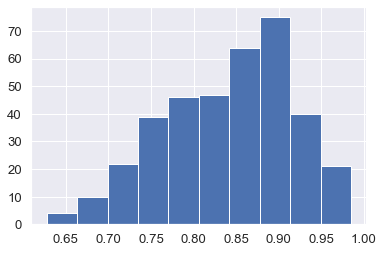

In [42]:
pd.Series(y_pred).hist()

In [27]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[309,   0],
       [ 59,   0]], dtype=int64)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Step 6: Non-linear classification models

## Step 7: Graph analysis (???)